# Proyecto 1 - Laboratorio de Aprendizaje Estadístico

In [1]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm

## Marco Teorico

**- Regresion lineal:** Es una técnica que modela la relación entre una variable dependiente (Salario) y una o más variables independientes (estadísticas de los jugadores) de manera lineal. Permite predecir valores de salario y analizar qué factores influyen más.
  
**- Regresion polinomial:** Se extiende la regresión lineal incluyendo potencias de las variables independientes. En este caso, solo se aplica a las variables cuyo p-value supera 0.2, ya que de lo contrario se generarían más variables que observaciones, lo que haría imposible resolver el sistema de ecuaciones utilizado para calcular los p-values de la regresión polinomial. Esta técnica resulta útil cuando la relación entre las variables no es estrictamente lineal.

**- Ridge:** Regresión lineal con penalización L2 que reduce la magnitud de los coeficientes grandes, ayudando a prevenir sobreajuste sin eliminar variables.

**- Lasso:** Regresión con penalización L1 que puede forzar algunos coeficientes a cero, ayudando a seleccionar solo las variables más relevantes para el modelo.

**- Elastic net:** Combina Lasso y Ridge, equilibrando selección de variables y control de magnitud de los coeficientes, especialmente útil cuando algunas variables están correlacionadas.

**- p values:** Se usan para evaluar la significancia estadística de los coeficientes; un p-value bajo indica que la variable tiene un efecto significativo sobre la variable dependiente.

## Analisis del Dataset
**¿De dónde viene?**
Los datos provienen de las Grandes Ligas de Béisbol de Estados Unidos, específicamente de las temporadas 1986 y 1987. Se tomaron de la biblioteca StatLib de la Universidad Carnegie Mellon y los salarios fueron originalmente publicados en Sports Illustrated en 1987.

**¿Qué contiene?**
El archivo CSV contiene 322 observaciones de jugadores y 20 variables. Entre ellas, se incluyen estadísticas de 1986: AtBat, Hits, HmRun, Carreras, RBI, Caminatas, Salidas, Asistencias, Errores. Estadísticas de carrera: CAtBat, CHits, CHmRun, CRuns, CRBI, CWalks. E Información categórica: Liga, División, NewLeague. El objetivo: Salario en miles de dólares para 1987.

**¿Qué información dan las muestras?**
Cada fila representa a un jugador y cada columna una característica del desempeño o su información de liga/división. Las muestras nos permiten analizar cómo las estadísticas individuales y acumuladas de los jugadores se relacionan con su salario.

**¿Qué se quiere analizar?**
Se quiere predecir el salario de los jugadores (Salario) usando sus estadísticas como variables explicativas. El objetivo del modelo de regresión es identificar qué factores influyen más en el salario y poder hacer predicciones para jugadores similares.

**¿Qué variables se tienen que transformar para poder usarse en un modelo de regresión?**
- Variables categóricas: Liga, División, NewLeague — codificadas a valores numéricos (0 y 1).
- Variable objetivo: Salario — se eliminaron filas con valores faltantes (NaN).
- Variables numéricas de entrada (X) — se estandarizaron para entrenamiento del modelo usando StandardScaler en x_train y x_test.

**¿Qué transformaciones se van a usar?**
- Codificación de variables categóricas.
- Escalamiento (estandarización) de todas las variables numéricas de entrada (x_train y x_test).
- Eliminación de filas con NaN en Salario para que el modelo pueda entrenar correctamente.

**¿Qué resultado se podría encontrar al realizar una regresión?**
- Coeficientes de regresión que indican el efecto de cada estadística en el salario.
- Evaluación del modelo con R² y MSE para medir ajuste en entrenamiento y prueba.
- Predicciones de salario para jugadores con estadísticas conocidas.
- Identificación de variables importantes y posibles redundancias, útil para entender qué estadísticas impactan más en el salario.

### Descarga de Datos

In [2]:
df = pd.read_csv("Hitters.csv")
df.dropna()
df = df[df['Salary'].notna()] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64(1), 

In [3]:
data = pd.get_dummies(df, columns = ['League', 'Division', 'NewLeague'])

### Funciones

In [4]:
def datos(data):


    x = data.drop(columns = ['Salary'])
    y = data['Salary']
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state=42)
    scaler = StandardScaler().fit(x_train)
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)
    x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)
    
    return x_train_scaled, x_test_scaled, y_train, y_test


def var_polinomiales(data, degree):


    poly = PolynomialFeatures(degree=degree, include_bias=False)
    pols = poly.fit_transform(data)
    feature_names = poly.get_feature_names_out(data.columns)
    data_poly = pd.DataFrame(pols, columns=feature_names, index=data.index)
    return data_poly


def datos_polinomiales(data, degree):


    x_train_scaled, x_test_scaled, y_train, y_test = datos(var_polinomiales(data, degree))
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    x_train_poly = poly.fit_transform(x_train_scaled)
    x_test_poly = poly.transform(x_test_scaled)
    
    feature_names = poly.get_feature_names_out(x_train_scaled.columns)
    
    x_train_poly = pd.DataFrame(x_train_poly, columns=feature_names, index=x_train_scaled.index)
    x_test_poly = pd.DataFrame(x_test_poly, columns=feature_names, index=x_test_scaled.index)
    
    return x_train_poly, x_test_poly, y_train, y_test


def dataframe_polinomial(degree):


    resultados = sin_penalizacion(data)[2]
    tabla = resultados.summary2().tables[1]
    tabla_filtrada = tabla[tabla['P>|t|'] > 0.2]  # no tomamos mayores a 0.05, sino los 8 valores de p-value mayores
    
    variables = tabla_filtrada.index.tolist()
    data_variables = data[variables]
    
    variables_poly = var_polinomiales(data_variables, degree=degree)
    
    data_nueva = data
    data_nueva = data.drop(columns=variables)
    
    data_nueva_variables = pd.concat([data_nueva, variables_poly], axis=1)
    return data_nueva_variables


def sin_penalizacion(data):


    x_train_scaled, x_test_scaled, y_train, y_test = datos(data)
    
    ols = sm.OLS(y_train, sm.add_constant(x_train_scaled))
    results = ols.fit()
    y_pred_train = results.predict(sm.add_constant(x_train_scaled))
    y_pred = results.predict(sm.add_constant(x_test_scaled))
    
    r2s = r2_score(y_test, y_pred)
    r2s = pd.DataFrame({'R2_test': [r2s]})
    res = results.summary()
    return res, r2s, results, y_pred, y_pred_train, y_test, y_train


def ridge(data, alpha):


    x_train_scaled, x_test_scaled, y_train, y_test = datos(data) 
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train_scaled, y_train)
    y_pred_train = ridge.predict(x_train_scaled)
    r2_train = r2_score(y_train, y_pred_train)
    y_pred = ridge.predict(x_test_scaled)
    r2 = r2_score(y_test, y_pred)

    res = pd.DataFrame({'Variables': x_train_scaled.columns, 'Coeficientes': ridge.coef_})
    r2s = pd.DataFrame({'R2_train': [r2_train], 'R2_test': [r2]})
    return res, r2s, y_pred_train, y_pred, y_train, y_test

def lasso(data, alpha):


    x_train_scaled, x_test_scaled, y_train, y_test = datos(data)
    lasso = Lasso(alpha = alpha, max_iter = 10_000)
    lasso.fit(x_train_scaled, y_train)
    y_pred_train = lasso.predict(x_train_scaled)
    r2_train = r2_score(y_train, y_pred_train)
    y_pred = lasso.predict(x_test_scaled)
    r2 = r2_score(y_test, y_pred)

    res = pd.DataFrame({'Variables': x_train_scaled.columns, 'Coeficientes': lasso.coef_})
    r2s = pd.DataFrame({'R2_train': [r2_train], 'R2_test': [r2]})
    return res, r2s

def elastic_net(data, alpha, ratio):

    
    x_train_scaled, x_test_scaled, y_train, y_test = datos(data)
    
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=ratio, max_iter=10_000)
    elastic_net.fit(x_train_scaled, y_train)
    y_pred_train = elastic_net.predict(x_train_scaled)
    r2_train = r2_score(y_train, y_pred_train)
    y_pred = elastic_net.predict(x_test_scaled)
    r2 = r2_score(y_test, y_pred)

    res = pd.DataFrame({'Variables': x_train_scaled.columns, 'Coeficientes': elastic_net.coef_})
    r2s = pd.DataFrame({'R2_train': [r2_train], 'R2_test': [r2]})
    return res, r2s

def nombres_dataframe(nombres, datos):


    for df, nombre in zip(datos, nombres):
        df["Modelo"] = nombre


### Variables para comparación

In [5]:
data_cuadrada = dataframe_polinomial(2)
data_cubica = dataframe_polinomial(3)

In [6]:
r2_lineal_train = sin_penalizacion(data)[2].rsquared
r2_lineal_test = float(sin_penalizacion(data)[1].values[0,0])

r2_cuadrada_train = sin_penalizacion(data_cuadrada)[2].rsquared
r2_cuadrada_test = float(sin_penalizacion(data_cuadrada)[1].values[0,0])

r2_cubica_train = sin_penalizacion(data_cubica)[2].rsquared
r2_cubica_test = float(sin_penalizacion(data_cubica)[1].values[0,0])

lineal = pd.DataFrame({'R2_train': [r2_lineal_train], 'R2_test': [r2_lineal_test]})
lineal_ridge = ridge(data, 1)[1]
lineal_lasso = lasso(data, 1)[1]
lineal_elastic = elastic_net(data, 1, 0.5)[1]

g2 = pd.DataFrame({'R2_train': [r2_cuadrada_train], 'R2_test': [r2_cuadrada_test]})
g2_ridge = ridge(data_cuadrada, 1)[1]
g2_lasso = lasso(data_cuadrada, 1)[1]
g2_elastic = elastic_net(data_cuadrada, 1, 0.5)[1]

g3 = pd.DataFrame({'R2_train': [r2_cubica_train], 'R2_test': [r2_cubica_test]})
g3_ridge = ridge(data_cubica, 1)[1]
g3_lasso = lasso(data_cubica, 1)[1]
g3_elastic = elastic_net(data_cubica, 1, 0.5)[1]

In [7]:
lineales = [lineal, lineal_ridge, lineal_lasso, lineal_elastic]
grado_2 = [g2, g2_ridge, g2_lasso, g2_elastic]
grado_3 = [g3, g3_ridge, g3_lasso, g3_elastic]

nombres_lineales = ["Regresión lineal sin penalización", 
                    "Regresión lineal con penalización Ridge", 
                    "Regresión lineal con penalización Lasso", 
                    "Regresión lineal con penalización ElasticNet"]

nombres_g2 = ["Regresión grado 2 sin penalización", 
              "Regresión grado 2 con penalización Ridge", 
              "Regresión grado 2 con penalización Lasso", 
              "Regresión grado 2 con penalización ElasticNet"]

nombres_g3 = ["Regresión grado 3 sin penalización", 
              "Regresión grado 3 con penalización Ridge", 
              "Regresión grado 3 con penalización Lasso", 
              "Regresión grado 3 con penalización ElasticNet"]

In [8]:
nombres_dataframe(nombres_lineales, lineales)
r2s_lineales = pd.concat(lineales, axis = 0)
r2s_lineales = r2s_lineales[["Modelo", "R2_train", "R2_test"]]

nombres_dataframe(nombres_g2, grado_2)
r2s_g2 = pd.concat(grado_2, axis = 0)
r2s_g2 = r2s_g2[["Modelo", "R2_train", "R2_test"]]

nombres_dataframe(nombres_g3, grado_3)
r2s_g3 = pd.concat(grado_3, axis = 0)
r2s_g3 = r2s_g3[["Modelo", "R2_train", "R2_test"]]

### Regresión lineal

In [9]:
sin_penalizacion(data)[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     13.12
Date:                Sat, 27 Sep 2025   Prob (F-statistic):           4.36e-24
Time:                        16:38:51   Log-Likelihood:                -1292.1
No. Observations:                 184   AIC:                             2624.
Df Residuals:                     164   BIC:                             2688.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         535.8383     21.185     25.294      0.000     494.008     577.668
AtBat        -191.3439    104.702     -1.828      0.069    -398.082      15.394
Hits          297.1558    109.671      2.710      0.007      80.607     513.705
HmRun          84.9538     64.213      1.323      0.188     -41.837     211.745
Runs          -36.1422     79.797     -0.453      0.651    -193.704     121.419
RBI           -74.9421     73.741     -1.016      0.311    -220.546      70.662
Walks          81.8926     41.687      1.964      0.051      -0.420     164.205
Years          96.4996     67.973      1.420      0.158     -37.716     230.716
CAtBat       -911.7612    386.421     -2.359      0.019   -1674.764    -148.759
CHits         457.4959    535.362      0.855      0.394    -599.594    1514.586
CHmRun         37.7194    177.950      0.212      0.832    -313.648     389.087
CRuns         526.0352    289.992      1.814      0.072     -46.564    1098.634
CRBI          169.5277    288.405      0.588      0.557    -399.938     738.994
CWalks       -163.8521     95.719     -1.712      0.089    -352.853      25.149
PutOuts        87.8384     24.105      3.644      0.000      40.241     135.436
Assists        53.1173     33.528      1.584      0.115     -13.085     119.319
Errors        -13.8171     30.738     -0.450      0.654     -74.511      46.877
League_A      -35.5627     20.839     -1.707      0.090     -76.710       5.584
League_N       35.5627     20.839      1.707      0.090      -5.584      76.710
Division_E     22.0914     11.094      1.991      0.048       0.185      43.998
Division_W    -22.0914     11.094     -1.991      0.048     -43.998      -0.185
NewLeague_A    15.3823     20.484      0.751      0.454     -25.065      55.829
NewLeague_N   -15.3823     20.484     -0.751      0.454     -55.829      25.065
==============================================================================
Omnibus:                        8.366   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               10.475
Skew:                           0.322   Prob(JB):                      0.00531
Kurtosis:                       3.976   Cond. No.                     4.48e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.57e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Análisis de significancia**

In [10]:
tabla = sin_penalizacion(data)[2].summary2().tables[1]
tabla_filtrada = tabla[tabla['P>|t|'] < 0.06]
display(Markdown("#### Factores de modelo sin penalización lineal"))
tabla_filtrada[['Std.Err.', 't', 'P>|t|']]

#### Factores de modelo sin penalización lineal

,Std.Err.,t,P>|t|
const,21.184727,25.293612,1.734893e-58
Hits,109.671043,2.709519,7.454154e-03
Walks,41.686921,1.964468,5.116571e-02
CAtBat,386.421413,-2.359500,1.947659e-02
PutOuts,24.105469,3.643922,3.599557e-04
Division_E,11.094461,1.991211,4.811834e-02
Division_W,11.094461,-1.991211,4.811834e-02


In [11]:
ridge(data, 1)[0]

,Variables,Coeficientes
0,AtBat,-199.559388
1,Hits,289.887062
2,HmRun,73.273902
3,Runs,-17.321385
4,RBI,-56.166674
5,Walks,75.590000
6,Years,35.772276
7,CAtBat,-320.705418
8,CHits,140.723455
9,CHmRun,49.719390


In [12]:
lasso(data, 1)[0]

,Variables,Coeficientes
0,AtBat,-2.141244e+02
1,Hits,3.025200e+02
2,HmRun,6.447799e+01
3,Runs,-2.195379e+01
4,RBI,-4.302229e+01
5,Walks,7.246259e+01
6,Years,4.424827e+01
7,CAtBat,-3.928808e+02
8,CHits,2.425419e+01
9,CHmRun,0.000000e+00


In [13]:
elastic_net(data, 1, 0.5)[0]

,Variables,Coeficientes
0,AtBat,15.808969
1,Hits,51.345039
2,HmRun,22.786881
3,Runs,32.841385
4,RBI,16.239586
5,Walks,23.333458
6,Years,16.829502
7,CAtBat,24.185327
8,CHits,37.727043
9,CHmRun,27.412571


#### Comparación de $R^2$

In [14]:
display(Markdown("### $R^2$ de los modelos lineales"))
r2s_lineales

### $R^2$ de los modelos lineales

,Modelo,R2_train,R2_test
0,Regresión lineal sin penalización,0.603260,0.380623
0,Regresión lineal con penalización Ridge,0.594157,0.403631
0,Regresión lineal con penalización Lasso,0.597100,0.404124
0,Regresión lineal con penalización ElasticNet,0.529303,0.353081


### Regresión grado 2

In [15]:
data_cuadrada = dataframe_polinomial(2)
data_cubica = dataframe_polinomial(3)

In [16]:
sin_penalizacion(data_cuadrada)[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     18.45
Date:                Sat, 27 Sep 2025   Prob (F-statistic):           4.69e-40
Time:                        16:38:51   Log-Likelihood:                -1195.6
No. Observations:                 184   AIC:                             2485.
Df Residuals:                     137   BIC:                             2636.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     535.8383     13.718     39.060      0.000     508.711     562.965
AtBat                      56.8659     81.924      0.694      0.489    -105.133     218.865
Hits                      -52.0170     90.656     -0.574      0.567    -231.284     127.250
HmRun                    -154.5649     58.373     -2.648      0.009    -269.993     -39.136
Walks                      17.0232     31.119      0.547      0.585     -44.512      78.558
Years                       3.7296     51.115      0.073      0.942     -97.347     104.807
CAtBat                  -1701.8105    315.094     -5.401      0.000   -2324.887   -1078.734
CRuns                     -19.2089    220.724     -0.087      0.931    -455.676     417.258
CWalks                      1.1541     75.298      0.015      0.988    -147.742     150.050
PutOuts                    79.2295     17.786      4.454      0.000      44.058     114.401
Assists                     6.2955     26.097      0.241      0.810     -45.310      57.901
League_A                  -31.2194     14.719     -2.121      0.036     -60.325      -2.114
League_N                   31.2194     14.719      2.121      0.036       2.114      60.325
Division_E                  8.7520      7.646      1.145      0.254      -6.368      23.872
Division_W                 -8.7520      7.646     -1.145      0.254     -23.872       6.368
Runs                     -171.8894     94.636     -1.816      0.072    -359.026      15.247
RBI                       100.7834     92.482      1.090      0.278     -82.093     283.660
CHits                    1483.6403    348.455      4.258      0.000     794.595    2172.686
CHmRun                    420.4772    222.126      1.893      0.060     -18.763     859.717
CRBI                     -359.3656    417.603     -0.861      0.391   -1185.146     466.415
Errors                     27.8114     40.540      0.686      0.494     -52.355     107.977
NewLeague_A                -0.1302     11.262     -0.012      0.991     -22.400      22.140
NewLeague_N                 0.1302     11.262      0.012      0.991     -22.140      22.400
Runs^2                   -252.3406    164.514     -1.534      0.127    -577.655      72.974
Runs RBI                  790.2563    293.502      2.693      0.008     209.877    1370.636
Runs CHits               1463.2962    588.494      2.487      0.014     299.590    2627.002
Runs CHmRun              1348.0405    510.513      2.641      0.009     338.536    2357.545
Runs CRBI               -2432.6505   1038.505     -2.342      0.021   -4486.223    -379.078
Runs Errors               212.1435     88.772      2.390      0.018      36.603     387.684
Runs NewLeague_A          -41.8250     52.950     -0.790      0.431    -146.530      62.880
Runs NewLeague_N          -96.5824     51.581  

**Análisis de significancia**

In [17]:
tabla = sin_penalizacion(data_cuadrada)[2].summary2().tables[1]
tabla_filtrada = tabla[tabla['P>|t|'] < 0.06]
display(Markdown("#### Factores de modelo sin penalización grado 2"))
tabla_filtrada[['Std.Err.', 't', 'P>|t|']]

#### Factores de modelo sin penalización grado 2

,Std.Err.,t,P>|t|
const,13.718228,39.060311,3.896241e-76
HmRun,58.372915,-2.647887,9.049732e-03
CAtBat,315.093959,-5.400962,2.847152e-07
PutOuts,17.786483,4.454480,1.731491e-05
League_A,14.718682,-2.121073,3.571676e-02
League_N,14.718682,2.121073,3.571676e-02
CHits,348.454835,4.257769,3.809349e-05
Runs RBI,293.501866,2.692509,7.976805e-03
Runs CHits,588.493696,2.486511,1.410193e-02
Runs CHmRun,510.513215,2.640559,9.237886e-03


In [18]:
ridge(data_cuadrada, 1)[0]

,Variables,Coeficientes
0,AtBat,-69.018819
1,Hits,140.851465
2,HmRun,-84.542601
3,Walks,48.699308
4,Years,-77.229070
5,CAtBat,-414.988389
6,CRuns,309.497035
7,CWalks,-74.573385
8,PutOuts,81.712894
9,Assists,-19.554098


In [19]:
lasso(data_cuadrada, 1)[0]

,Variables,Coeficientes
0,AtBat,0.000000e+00
1,Hits,3.409458e+01
2,HmRun,-9.548441e+01
3,Walks,2.376546e+01
4,Years,-3.652049e+01
5,CAtBat,-1.174362e+03
6,CRuns,1.837732e+02
7,CWalks,-0.000000e+00
8,PutOuts,8.261202e+01
9,Assists,-5.360429e+00


In [20]:
elastic_net(data_cuadrada, 1, 0.5)[0]

,Variables,Coeficientes
0,AtBat,0.854778
1,Hits,29.025143
2,HmRun,0.000000
3,Walks,15.301269
4,Years,4.895961
5,CAtBat,14.887193
6,CRuns,32.643846
7,CWalks,19.960686
8,PutOuts,55.999154
9,Assists,-0.000000


## Pipeline

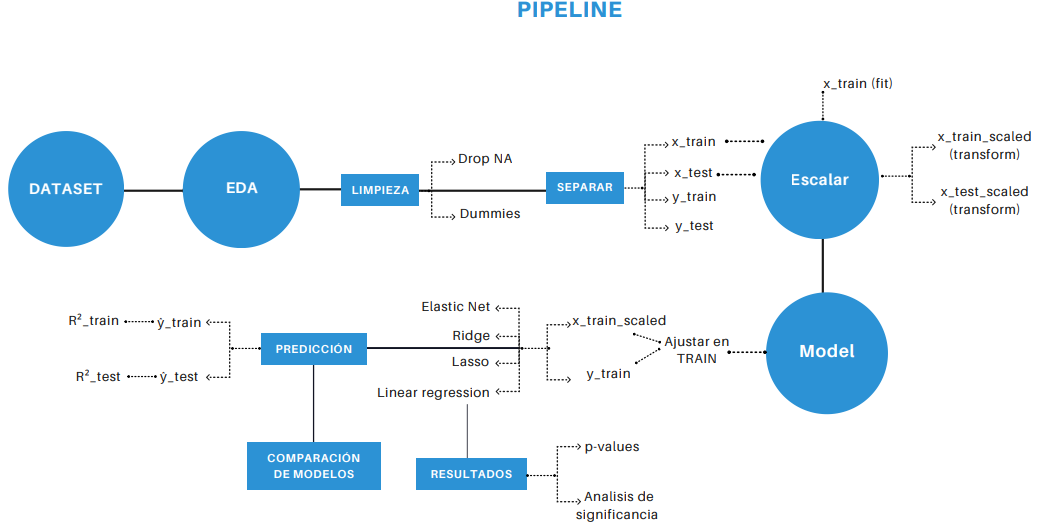

#### Comparación $R^2$

In [21]:
display(Markdown("### $R^2$ de los modelos polinomiales grado 2"))
r2s_g2

### $R^2$ de los modelos polinomiales grado 2

,Modelo,R2_train,R2_test
0,Regresión grado 2 sin penalización,0.861026,0.407619
0,Regresión grado 2 con penalización Ridge,0.799778,0.475286
0,Regresión grado 2 con penalización Lasso,0.825276,0.470247
0,Regresión grado 2 con penalización ElasticNet,0.631365,0.428992


### Grado 3

In [22]:
sin_penalizacion(data_cubica)[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     14.93
Date:                Sat, 27 Sep 2025   Prob (F-statistic):           1.27e-22
Time:                        16:38:52   Log-Likelihood:                -1059.4
No. Observations:                 184   AIC:                             2367.
Df Residuals:                      60   BIC:                             2765.
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                            535.8383      9.890     54.177      0.000     516.054     555.622
AtBat                            158.7750    107.340      1.479      0.144     -55.936     373.486
Hits                            -197.9426    129.699     -1.526      0.132    -457.378      61.493
HmRun                             14.9406     78.373      0.191      0.849    -141.829     171.711
Walks                            -12.8007     44.540     -0.287      0.775    -101.894      76.293
Years                            -42.0179     72.506     -0.580      0.564    -187.052     103.017
CAtBat                         -2151.5475    597.148     -3.603      0.001   -3346.021    -957.074
CRuns                           -295.0201    331.463     -0.890      0.377    -958.046     368.005
CWalks                           136.1641    148.644      0.916      0.363    -161.168     433.496
PutOuts                           44.4233     21.467      2.069      0.043       1.482      87.364
Assists                            6.0830     26.762      0.227      0.821     -47.449      59.615
League_A                         -41.1692     16.992     -2.423      0.018     -75.159      -7.180
League_N                          41.1691     16.992      2.423      0.018       7.180      75.159
Division_E                        -2.0504      8.612     -0.238      0.813     -19.277      15.177
Division_W                         2.0504      8.612      0.238      0.813     -15.177      19.277
Runs                            -350.8290    224.975     -1.559      0.124    -800.847      99.189
RBI                              -84.9153    222.644     -0.381      0.704    -530.270     360.439
CHits                           1712.6048    879.221      1.948      0.056     -46.098    3471.308
CHmRun                           721.4778    581.132      1.242      0.219    -440.959    1883.914
CRBI                            -971.2756   1299.291     -0.748      0.458   -3570.246    1627.694
Errors                           178.5498     88.737      2.012      0.049       1.050     356.050
NewLeague_A                       -0.7275     16.191     -0.045      0.964     -33.114      31.659
NewLeague_N                        0.7275     16.191      0.045      0.964     -31.659      33.114
Runs^2                          -322.8954    842.482     -0.383      0.703   -2008.109    1362.319
Runs RBI                        1713.6610   1416.794      1.210      0.231   -1120.348    4547.670
Runs CHits                       293.0028   3409.458      0.086      0.932   -6526.929    7112.934
Runs CHmRun                     -896.6297   2242.963     -0.400      0.691   -5383.224    3589.965
Runs CRBI                        -55.6496   5303.221     -0.010      0.992   -1.07e+04    1.06e+04
Runs Errors   

**Análisis de significancia**

In [23]:
tabla = sin_penalizacion(data_cubica)[2].summary2().tables[1]
tabla_filtrada = tabla[tabla['P>|t|'] < 0.06]
display(Markdown("#### Factores de modelo sin penalización grado 3"))
tabla_filtrada[['Std.Err.', 't', 'P>|t|']]

#### Factores de modelo sin penalización grado 3

,Std.Err.,t,P>|t|
const,9.890472,54.177215,1.167337e-52
CAtBat,597.147665,-3.603041,6.399260e-04
PutOuts,21.467394,2.069339,4.282918e-02
League_A,16.992281,-2.422815,1.843607e-02
League_N,16.992283,2.422814,1.843612e-02
CHits,879.220517,1.947867,5.611377e-02
Errors,88.736854,2.012127,4.870264e-02
Runs NewLeague_A,104.510590,-2.026575,4.715741e-02
Errors NewLeague_N,54.764276,2.276575,2.639290e-02
Runs NewLeague_A^2,104.510591,-2.026575,4.715742e-02


In [24]:
ridge(data_cubica, 1)[0]

,Variables,Coeficientes
0,AtBat,-17.262003
1,Hits,67.866510
2,HmRun,-69.656346
3,Walks,33.648582
4,Years,-49.775180
...,...,...
173,Errors NewLeague_N^2,30.153108
174,NewLeague_A^3,13.898360
175,NewLeague_A^2 NewLeague_N,0.000000
176,NewLeague_A NewLeague_N^2,0.000000


In [25]:
lasso(data_cubica, 1)[0]

,Variables,Coeficientes
0,AtBat,0.474711
1,Hits,23.626147
2,HmRun,-67.675944
3,Walks,22.656311
4,Years,-19.801481
...,...,...
173,Errors NewLeague_N^2,0.000000
174,NewLeague_A^3,0.129337
175,NewLeague_A^2 NewLeague_N,0.000000
176,NewLeague_A NewLeague_N^2,0.000000


In [26]:
elastic_net(data_cubica, 1, 0.5)[0]

,Variables,Coeficientes
0,AtBat,2.471654
1,Hits,22.359702
2,HmRun,-11.181716
3,Walks,11.313165
4,Years,2.805896
...,...,...
173,Errors NewLeague_N^2,-0.688813
174,NewLeague_A^3,-0.000000
175,NewLeague_A^2 NewLeague_N,0.000000
176,NewLeague_A NewLeague_N^2,0.000000


#### Comparación $R^2$

In [27]:
display(Markdown("### $R^2$ de los modelos polinomiales grado 3"))
r2s_g3

### $R^2$ de los modelos polinomiales grado 3

,Modelo,R2_train,R2_test
0,Regresión grado 3 sin penalización,0.968363,-1.954720
0,Regresión grado 3 con penalización Ridge,0.875765,0.412473
0,Regresión grado 3 con penalización Lasso,0.860321,0.417089
0,Regresión grado 3 con penalización ElasticNet,0.723480,0.411073


## Comparación de los modelos propuestos

In [28]:
dfs = [lineal, lineal_ridge, 
       lineal_lasso, lineal_elastic, 
       g2, g2_ridge, 
       g2_lasso, g2_elastic, 
       g3, g3_ridge, 
       g3_lasso, g3_elastic]

nombres = ["Lineal", "Lineal con penalización Ridge", 
           "Lineal con penalización Lasso", "Lineal con penalización ElasticNet", 
           "Grado 2", "Grado 2 con penalización Ridge", 
           "Grado 2 con penalización Lasso", "Grado 2 con penalización ElasticNet", 
           "Grado 3", "Grado 3 con penalización Ridge", 
           "Grado 3 con penalización Lasso", "Grado 3 con penalización ElasticNet"]

for df, nombre in zip(dfs, nombres):
    df["Modelo"] = nombre


df_final = pd.concat(dfs, ignore_index=True)
df_final = df_final[["Modelo", "R2_train", "R2_test"]]

display(Markdown("### $R^2$ de los modelos utilizados"))
display(Markdown(df_final.to_markdown(index = False)))


### $R^2$ de los modelos utilizados

| Modelo                              |   R2_train |   R2_test |
|:------------------------------------|-----------:|----------:|
| Lineal                              |   0.60326  |  0.380623 |
| Lineal con penalización Ridge       |   0.594157 |  0.403631 |
| Lineal con penalización Lasso       |   0.5971   |  0.404124 |
| Lineal con penalización ElasticNet  |   0.529303 |  0.353081 |
| Grado 2                             |   0.861026 |  0.407619 |
| Grado 2 con penalización Ridge      |   0.799778 |  0.475286 |
| Grado 2 con penalización Lasso      |   0.825276 |  0.470247 |
| Grado 2 con penalización ElasticNet |   0.631365 |  0.428992 |
| Grado 3                             |   0.968363 | -1.95472  |
| Grado 3 con penalización Ridge      |   0.875765 |  0.412473 |
| Grado 3 con penalización Lasso      |   0.860321 |  0.417089 |
| Grado 3 con penalización ElasticNet |   0.72348  |  0.411073 |

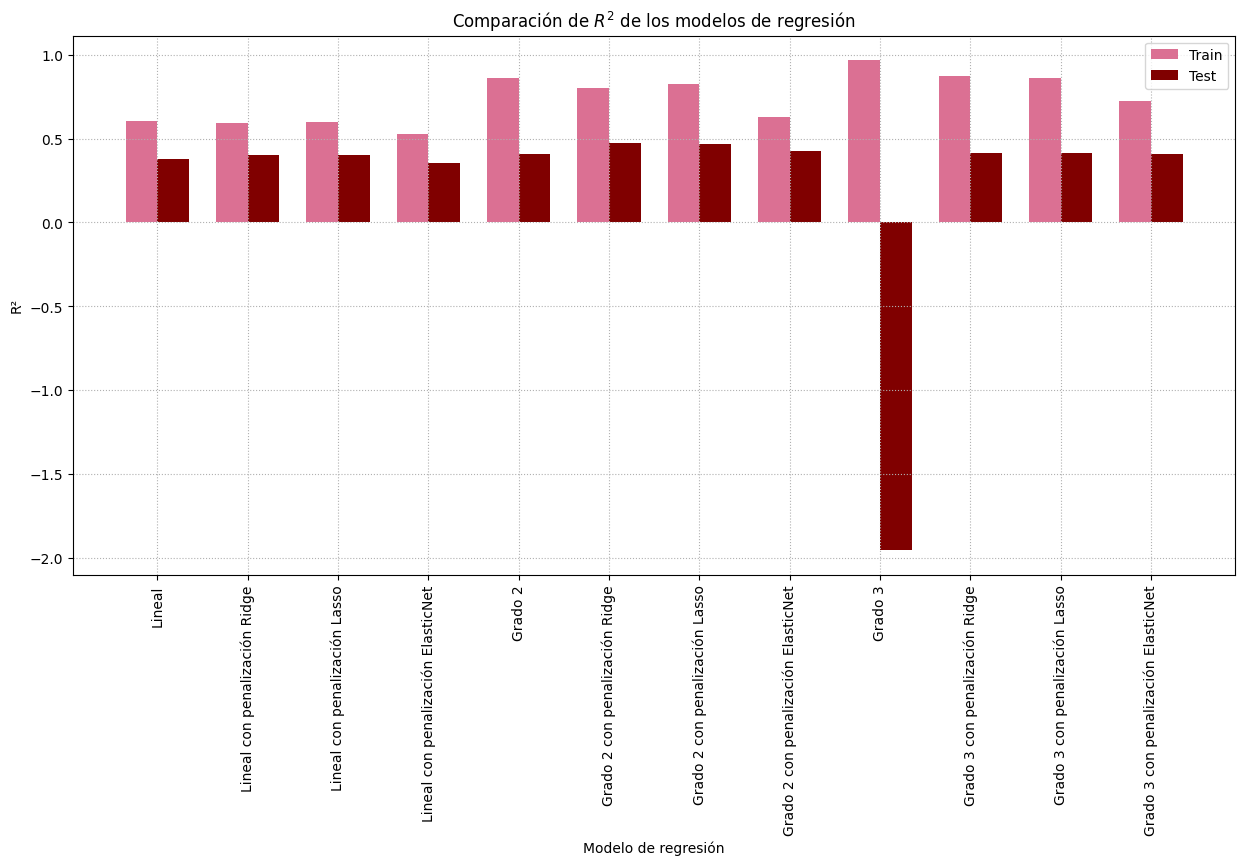

In [29]:
x = np.arange(len(df_final))  
width = 0.35  

plt.figure(figsize=(15,7))

plt.bar(x - width/2, df_final["R2_train"], width, label="Train", color = "palevioletred")
plt.bar(x + width/2, df_final["R2_test"], width, label="Test", color = "maroon")

plt.xticks(x, df_final["Modelo"], rotation=90)
plt.title("Comparación de $R^2$ de los modelos de regresión")
plt.xlabel("Modelo de regresión")
plt.ylabel("R²")
plt.legend()
plt.grid(linestyle=":")

In [30]:
mejor_train, mejor_test = ridge(data_cuadrada, 1)[2], ridge(data_cuadrada, 1)[3]
datos_reales_train, datos_reales_test = ridge(data_cuadrada, 1)[4], ridge(data_cuadrada, 1)[5]


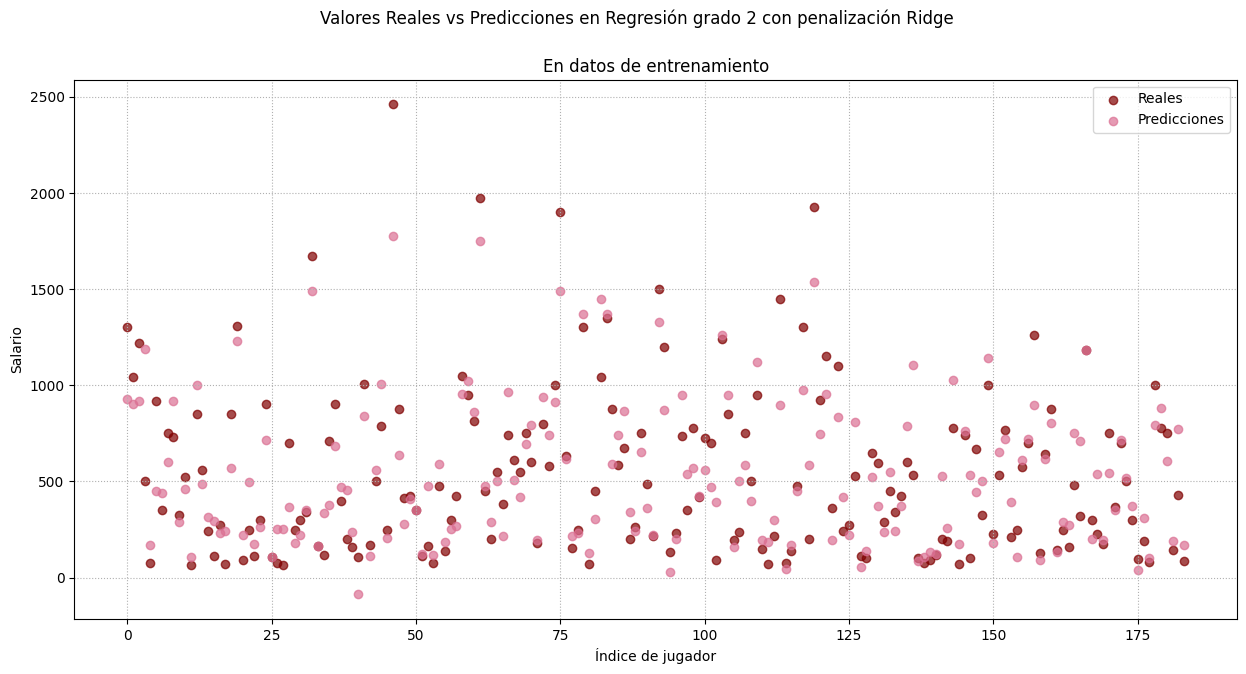

In [31]:
plt.figure(figsize=(15,7))
plt.scatter(range(len(datos_reales_train)), datos_reales_train, 
            color='maroon', label='Reales', alpha = 0.7)

plt.scatter(range(len(mejor_train)), mejor_train, 
            color='palevioletred', label='Predicciones', alpha = 0.7)

plt.xlabel("Índice de jugador")
plt.ylabel("Salario")
plt.title("En datos de entrenamiento")
plt.suptitle("Valores Reales vs Predicciones en Regresión grado 2 con penalización Ridge")
plt.legend()
plt.grid(linestyle=":")


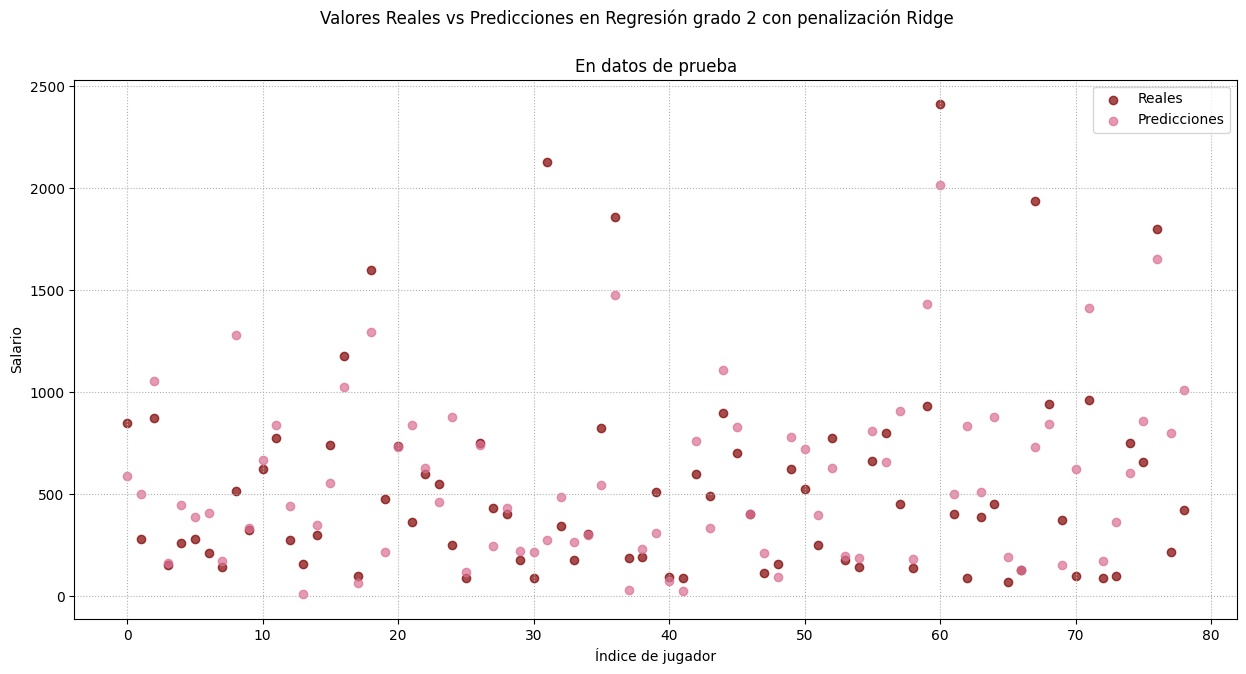

In [32]:
plt.figure(figsize=(15,7))
plt.scatter(range(len(datos_reales_test)), datos_reales_test, 
            color='maroon', label='Reales', alpha = 0.7)

plt.scatter(range(len(mejor_test)), mejor_test, 
            color='palevioletred', label='Predicciones', alpha = 0.7)

plt.xlabel("Índice de jugador")
plt.ylabel("Salario")
plt.title("En datos de prueba")
plt.suptitle("Valores Reales vs Predicciones en Regresión grado 2 con penalización Ridge")
plt.legend()
plt.grid(linestyle=":")

In [33]:
sobreajuste_train, sobreajuste_test = sin_penalizacion(data_cubica)[4], sin_penalizacion(data_cubica)[3]
datos_reales_train_c, datos_reales_test_c = sin_penalizacion(data_cubica)[6], sin_penalizacion(data_cubica)[5]

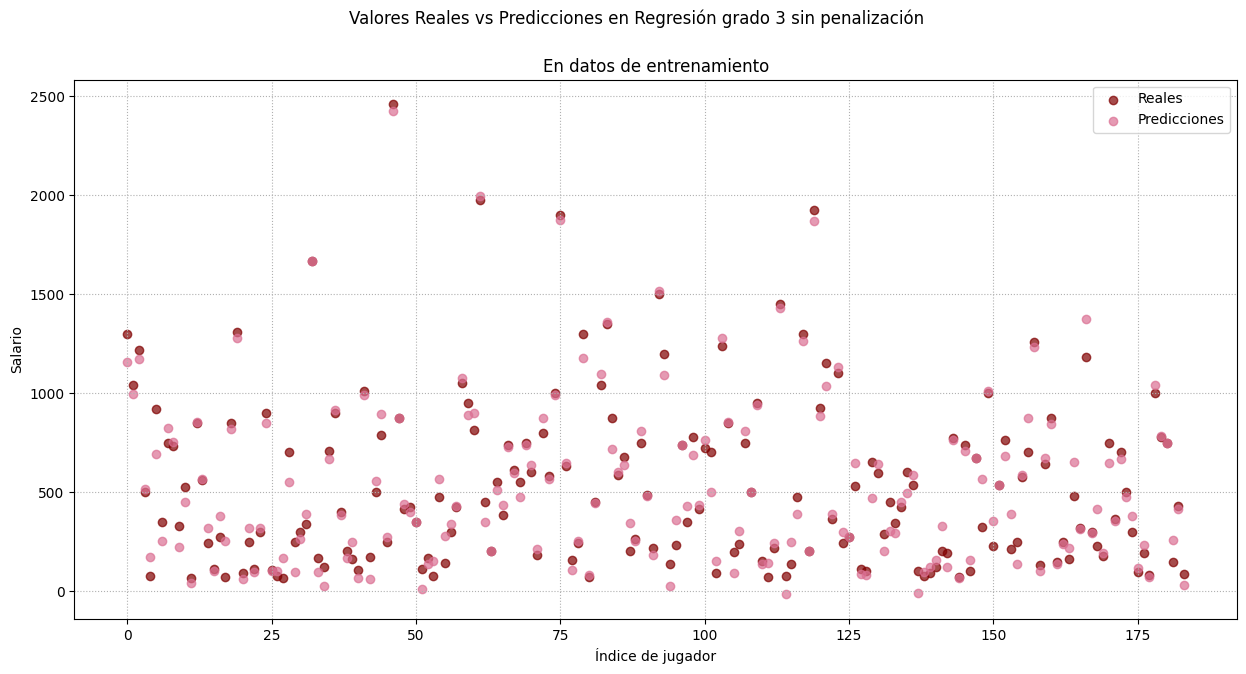

In [34]:
plt.figure(figsize=(15,7))
plt.scatter(range(len(datos_reales_train_c)), datos_reales_train_c, 
            color='maroon', label='Reales', alpha = 0.7)

plt.scatter(range(len(sobreajuste_train)), sobreajuste_train, 
            color='palevioletred', label='Predicciones', alpha = 0.7)

plt.xlabel("Índice de jugador")
plt.ylabel("Salario")
plt.title("En datos de entrenamiento")
plt.suptitle("Valores Reales vs Predicciones en Regresión grado 3 sin penalización")
plt.legend()
plt.grid(linestyle=":")

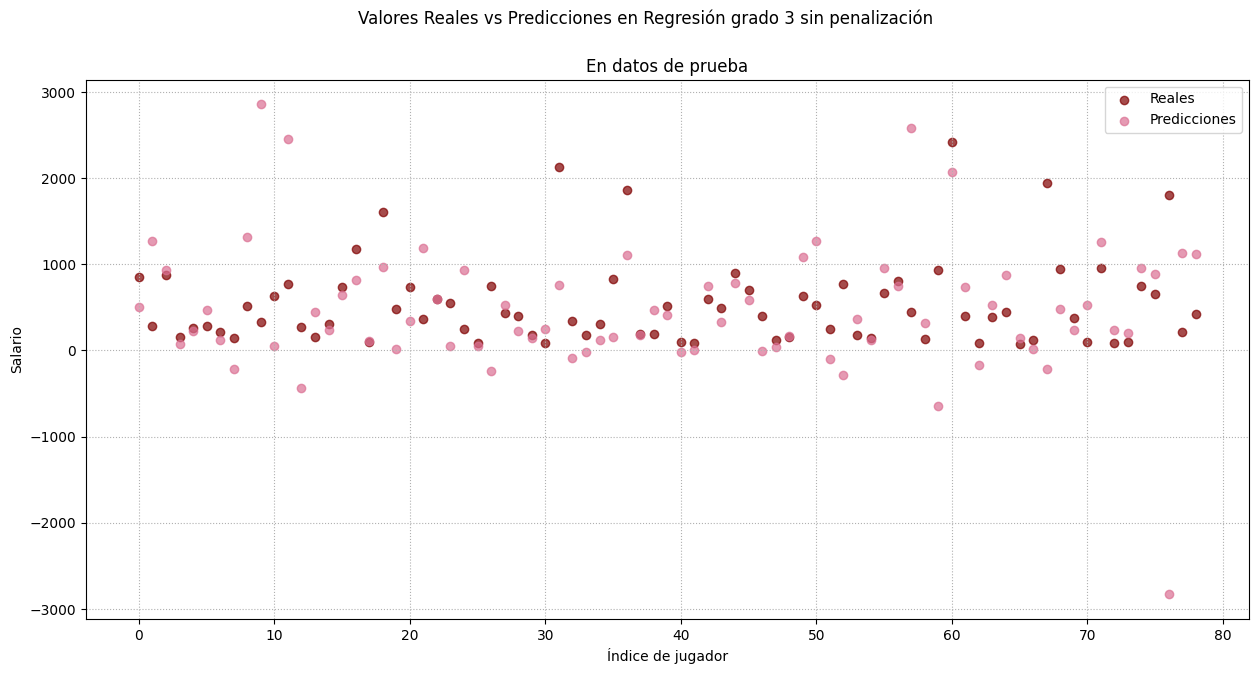

In [35]:
plt.figure(figsize=(15,7))
plt.scatter(range(len(datos_reales_test_c)), datos_reales_test_c, 
            color='maroon', label='Reales', alpha = 0.7)

plt.scatter(range(len(sobreajuste_test)), sobreajuste_test, 
            color='palevioletred', label='Predicciones', alpha = 0.7)

plt.xlabel("Índice de jugador")
plt.ylabel("Salario")
plt.title("En datos de prueba")
plt.suptitle("Valores Reales vs Predicciones en Regresión grado 3 sin penalización ")
plt.legend()
plt.grid(linestyle=":")

### Referencias

Scikit-learn developers. (2023). sklearn.preprocessing.PolynomialFeatures. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Seabold, S., & Perktold, J. (2025). statsmodels.regression.linear_model.OLS. Statsmodels. https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html

Scikit-learn developers. (2023). sklearn.metrics.r2_score. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

MathChi. (2018). Hitters Baseball Data. Kaggle. https://www.kaggle.com/datasets/mathchi/hitters-baseball-data